#  **Solving 1D Radiative Transfer Equation (RTE) Using PINNs**

# **📚 References**

#### **Equations and Analytical Solution**
- Modest, M. F., & Mazumder, S. , **_"Radiative Heat Transfer"_**, 4th Edition, Academic Press, 2021.

#### **Coding Assistance**
- Code support and guidance were provided using OpenAI's ChatGPT.




# Physics-Informed Neural Network for a 1D Gray Medium Without Scattering

## Problem Description
We aim to solve the 1D radiative transfer equation (RTE) in a **gray, absorbing-emitting** medium **without scattering**:
$$ 
\mu \frac{dI(x, \mu)}{dx} + \kappa I(x, \mu) = \kappa \sigma T(x)^4
$$
- $I(x, \mu) $: Radiative intensity at position \( x \) in direction $\mu$
- $\kappa $: Absorption coefficient (constant)
- $ \sigma $: Stefan-Boltzmann constant
- $T(x) $: Known temperature profile of the medium
- $ \mu $: Direction cosine

**Domain:** $ x \in [0, 1] $, with two discrete directions $\mu = \pm 1 $

In [97]:
# ---------------------------
# Imports and Setup
# ---------------------------

# PyTorch for building and training neural networks
import torch
import torch.nn as nn

# NumPy for numerical operations
import numpy as np

# Matplotlib for plotting results
import matplotlib.pyplot as plt

# ---------------------------
# Device Configuration
# ---------------------------

# Use GPU if available, otherwise fallback to CPU
# Uncomment the line below to enable automatic device selection
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# For now, manually set to CPU for compatibility
device = 'cpu'

# ---------------------------
# Problem Setup for 1D RTE
# ---------------------------

kappa = 0.1                            # Absorption coefficient
sigma = 0.1                             # Stefan-Boltzmann constant (increased to amplify signal)
T_func = lambda x: 1.0 + 0.5 * x        # Prescribed temperature profile (linear function)

mu_vals = [1.0, -1.0]                   # Two angular directions: right (+1.0) and left (-1.0)

# Domain limits in the spatial dimension
x_min, x_max = 0.0, 1.0



## PINN Architecture
The neural network takes two inputs $x $ and $ \mu $, and predicts $ I(x, \mu) $.

**Loss function includes:**
- Residual of the RTE (physics loss)
- Boundary condition loss for $ \mu = \pm 1 \$

In [110]:
# ---------------------------
# Neural Network Definition
# ---------------------------

# Define the PINN model for 1D Radiative Transfer Equation (RTE)
class PINN(nn.Module):
    def __init__(self):
        super(PINN, self).__init__()
        
        # Define a fully connected feedforward neural network using nn.Sequential
        # Input: 2 features -> spatial position (x) and angle (mu)
        # Hidden layers: two layers with 32 neurons each and Tanh activation
        # Output: 1 scalar value representing the intensity I(x, mu)
        self.net = nn.Sequential(
            nn.Linear(2, 32),     # First layer: input (x, mu) -> 32 neurons
            nn.Tanh(),           # Activation function (non-linear transformation)
            nn.Linear(32, 32),     # Second hidden layer: 32 -> 32
            nn.Tanh(),           # Another Tanh activation
            # Optional third layer can be added here if needed
            nn.Linear(32, 1)      # Output layer: 32 -> 1 (scalar output: intensity)
        )

    def forward(self, x, mu):
        # Forward pass: concatenate x and mu along the feature dimension
        # and pass through the network
        inputs = torch.cat([x, mu], dim=1)  # Combine position and angle
        return self.net(inputs)             # Predict intensity I(x, mu)


## Boundary Conditions (BC)
- For $\mu > 0 $, the boundary is at $ x = 0 $: $ I(0, \mu) = 0 $
- For $\mu < 0 $, the boundary is at $x = 1 $: $I(1, \mu) = 0 $

These are typical **vacuum boundary conditions**, meaning no incoming radiation from the surroundings.

In [116]:
# ---------------------------
# Loss Function for PINN
# ---------------------------

def loss_fn(model, x_colloc, mu_colloc):
    # Enable gradient computation for x_colloc (required for computing dI/dx)
    x_colloc.requires_grad_(True)

    # No need to compute gradients with respect to mu_colloc
    mu_colloc.requires_grad_(False)

    # Predict intensity I(x, mu) using the PINN model
    I_pred = model(x_colloc, mu_colloc)

    # Compute the spatial derivative dI/dx using automatic differentiation
    dI_dx = torch.autograd.grad(
        I_pred, x_colloc,
        grad_outputs=torch.ones_like(I_pred),  # Gradient seed
        create_graph=True                      # Keep computation graph for further differentiation
    )[0]

    # Evaluate temperature T(x) at collocation points and compute the source term: κσT⁴
    T_vals = T_func(x_colloc)
    source = kappa * sigma * T_vals**4

    # Residual of the 1D RTE: μ * dI/dx + κ * I - κσT⁴ = 0
    residual = mu_colloc * dI_dx + kappa * I_pred - source

    # Physics-informed loss: Mean squared error of the residuals
    loss_phys = torch.mean(residual**2)

    # ----------------------------------------
    # Boundary Condition Loss (Dirichlet type)
    # ----------------------------------------

    # Create tensors for boundary points and directions
    x_left = torch.tensor([[x_min]], dtype=torch.float32, device=device)    # Left boundary x = 0
    x_right = torch.tensor([[x_max]], dtype=torch.float32, device=device)   # Right boundary x = 1
    mu_left = torch.tensor([[mu_vals[0]]], dtype=torch.float32, device=device)   # μ > 0 (incoming on left)
    mu_right = torch.tensor([[mu_vals[1]]], dtype=torch.float32, device=device)  # μ < 0 (incoming on right)

    # Compute predicted boundary intensities
    I_left = model(x_left, mu_left)
    I_right = model(x_right, mu_right)

    # Apply boundary condition: I(x=0, μ>0) = 0 and I(x=1, μ<0) = 0
    loss_bc = (I_left - 0.0)**2 + (I_right - 0.0)**2

    # Total loss = physics loss + boundary condition loss
    return loss_phys + loss_bc


In [117]:
# ---------------------------
# Training Function for PINN
# ---------------------------

def train(model, optimizer, epochs=1000):
    for epoch in range(epochs):
        optimizer.zero_grad()  # Reset gradients from the previous step

        # ----------------------------------------
        # Generate Collocation Points for Training
        # ----------------------------------------

        # Sample 1000 random x-values uniformly from the domain [x_min, x_max]
        x_colloc = torch.tensor(
            np.random.uniform(x_min, x_max, (1000, 1)),
            dtype=torch.float32,
            device=device
        )

        # Sample 1000 random μ-values from the discrete list [1.0, -1.0]
        mu_colloc = torch.tensor(
            np.random.choice(mu_vals, size=(1000, 1)),
            dtype=torch.float32,
            device=device
        )

        # Compute total loss: physics + boundary conditions
        loss = loss_fn(model, x_colloc, mu_colloc)

        # Backpropagation: compute gradients
        loss.backward()

        # Update model parameters using optimizer (e.g., Adam)
        optimizer.step()

        # Logging: print loss every 100 epochs
        if epoch % 100 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.6f}")


In [121]:
# ---------------------------
# Run Training
# ---------------------------

# Initialize the PINN model and move it to the chosen device (CPU or GPU)
model = PINN().to(device)

# Set up the optimizer: using Adam with a learning rate of 1e-3
# Adam is well-suited for neural network training with adaptive learning rates
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# Train the model using the defined training function
# This will optimize the network to minimize the combined PDE + boundary condition loss
train(model, optimizer)


Epoch 0, Loss: 0.139902
Epoch 100, Loss: 0.000403
Epoch 200, Loss: 0.000234
Epoch 300, Loss: 0.000138
Epoch 400, Loss: 0.000072
Epoch 500, Loss: 0.000039
Epoch 600, Loss: 0.000026
Epoch 700, Loss: 0.000020
Epoch 800, Loss: 0.000020
Epoch 900, Loss: 0.000019


## Analytical Solution
For a linear temperature profile $T(x) = 1 + 0.5x$, the solution is:
$$ 
I(x, \mu) = \int_{s=0}^{x} \frac{\kappa \sigma T(s)^4}{\mu} e^{\frac{-\kappa (x - s)}{\mu}} ds \quad \text{for } \mu > 0 $$
$$
I(x, \mu) = \int_{s=x}^{1} \frac{\kappa \sigma T(s)^4}{|\mu|} e^{\frac{-\kappa (s - x)}{|\mu|}} ds \quad \text{for } \mu < 0
$$

In [124]:
# ---------------------------
# Analytical Solution Function
# ---------------------------

def analytical_I(x_vals, mu_val):
    """
    Compute the analytical solution of the 1D Radiative Transfer Equation (RTE)
    for a given mu (direction cosine) using numerical integration (trapezoidal rule).
    
    Args:
        x_vals : array-like
            Spatial positions at which to evaluate intensity I(x, mu)
        mu_val : float
            Direction cosine (positive for left-to-right, negative for right-to-left)

    Returns:
        np.array: Analytical intensity values at each x in x_vals
    """
    x_vals = np.atleast_1d(x_vals)  # Ensure input is an array
    I_vals = []                     # Store results for each x

    for x in x_vals:
        # If mu > 0, integrate from s = 0 to x (left-to-right radiation)
        if mu_val > 0:
            s = np.linspace(0, x, 20)  # Discrete integration points
            T_s = 1.0 + 0.5 * s        # Temperature profile T(s)
            # Integrand of the exact solution
            integrand = (
                kappa * sigma * T_s**4 *
                np.exp(-kappa * (x - s) / mu_val) / mu_val
            )
        # If mu < 0, integrate from s = x to 1 (right-to-left radiation)
        else:
            s = np.linspace(x, 1.0, 20)
            T_s = 1.0 + 0.5 * s
            integrand = (
                kappa * sigma * T_s**4 *
                np.exp(-kappa * (s - x) / abs(mu_val)) / abs(mu_val)
            )

        # Numerically integrate the source term using the trapezoidal rule
        I_vals.append(np.trapz(integrand, s))

    return np.array(I_vals)


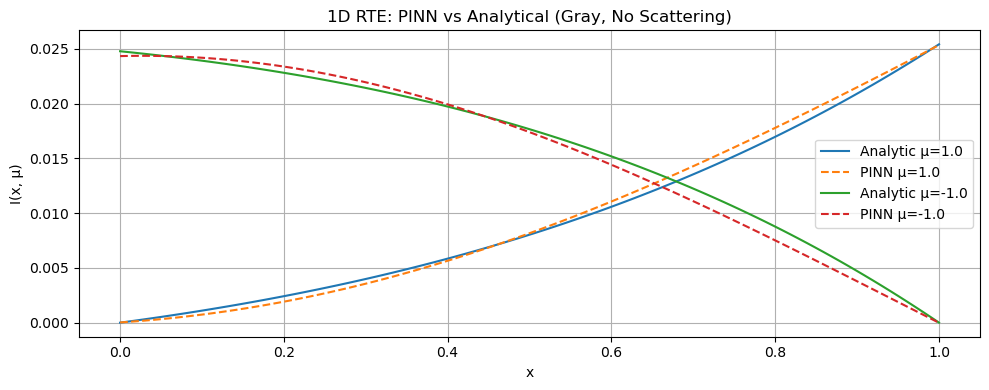

In [126]:
# ---------------------------
# Plotting PINN vs Analytical Solution
# ---------------------------

plt.figure(figsize=(10, 4))  # Set figure size

# Loop over each mu value (angular direction)
for mu_val in mu_vals:
    # Create a tensor of repeated mu values for the entire x_test domain
    mu_tensor = torch.tensor([[mu_val]] * len(x_test), dtype=torch.float32, device=device)

    # Predict intensity I(x, mu) using the trained PINN model
    with torch.no_grad():
        I_pred = model(x_tensor, mu_tensor).cpu().numpy()

    # Compute analytical solution I(x, mu) using formal solution
    I_true = analytical_I(x_test.flatten(), mu_val)

    # Plot analytical solution
    plt.plot(x_test, I_true, label=f"Analytic μ={mu_val}", linestyle='-')

    # Plot PINN-predicted solution
    plt.plot(x_test, I_pred, label=f"PINN μ={mu_val}", linestyle='--')

# Labeling and styling
plt.xlabel("x")                           # x-axis label
plt.ylabel("I(x, μ)")                    # y-axis label
plt.title("1D RTE: PINN vs Analytical (Gray, No Scattering)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()                                # Display the plot


## Conclusion
- The PINN successfully solves the 1D RTE in a gray medium without scattering.
- The predicted radiative intensity matches the analytical solution well.
- This validates the ability of PINNs to handle integro-differential problems like RTE.